# <center>Gold price prediction</center>

## <center>1. Forecasting the price of the gold using ARIMA model</center>

### Importing the required modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_column',None)

In [2]:
data = pd.read_csv('FINAL_USO.xls',usecols=['Date','Close'])

In [3]:
data['Date'] = pd.to_datetime(data['Date'])

In [4]:
data.set_index('Date',inplace=True)
data.head()

,Close
Date,
2011-12-15,152.330002
2011-12-16,155.229996
2011-12-19,154.869995
2011-12-20,156.979996
2011-12-21,157.160004


### Plotting the stock close price

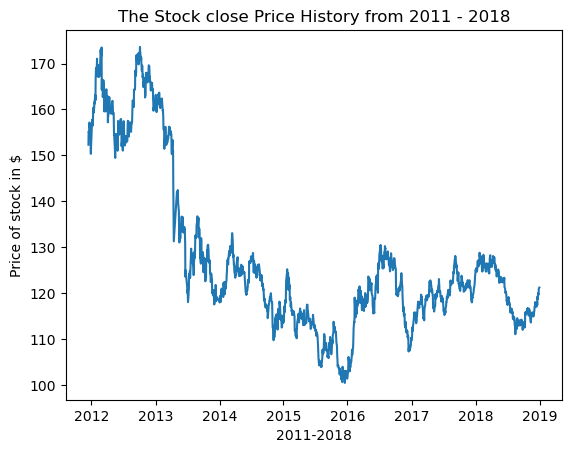

In [5]:
plt.title('The Stock close Price History from 2011 - 2018')
plt.plot(data['Close'])
plt.xlabel('2011-2018')
plt.ylabel('Price of stock in $')
plt.show()

### Testing for stationarity

In [6]:
from statsmodels.tsa.stattools import adfuller

In [7]:
def ad_test(d):
    a = adfuller(d)
    print('P value : ',a[1])
    print('#Lags used : ',a[2])
    print('No. of observations used : ',a[3])
    print('It is stationary we accept H0') if a[1]<=0.05 else print('It is not stationary we reject H0')

In [8]:
ad_test(data['Close'].dropna())

P value :  0.3688781538232949
#Lags used :  1
No. of observations used :  1716
It is not stationary we reject H0


### Differencing to make the data stationary

In [9]:
data['first_diff'] = data['Close'] - data['Close'].shift(1)

In [10]:
ad_test(data['first_diff'].dropna())

P value :  0.0
#Lags used :  1
No. of observations used :  1715
It is stationary we accept H0


### Plotting the differencing plot

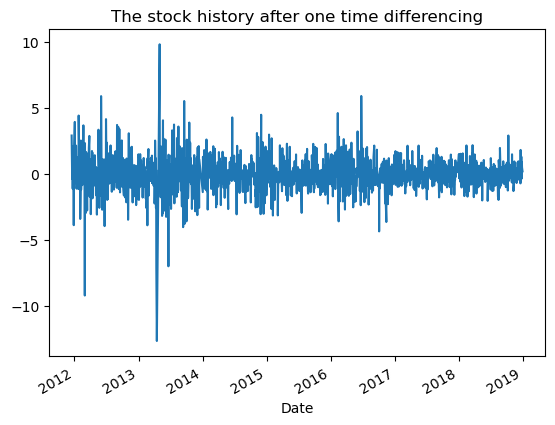

In [11]:
data['first_diff'].plot()
plt.title('The stock history after one time differencing')
plt.show()

### Deploying the Auto Regressive Integrated Moving Average (ARIMA) Model

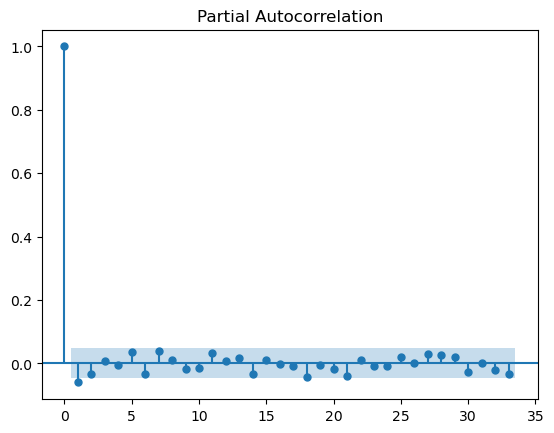

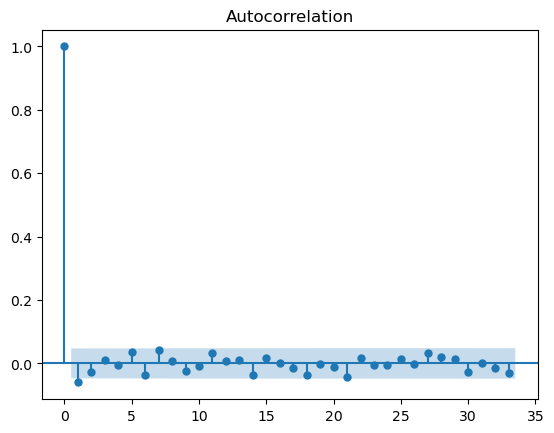

In [12]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

plot_pacf(data['first_diff'].iloc[1:])
plot_acf(data['first_diff'].iloc[1:])
plt.show()

### Fitting and Forecasting of the ARIMA Model

C:\Users\tyoge\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\tyoge\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


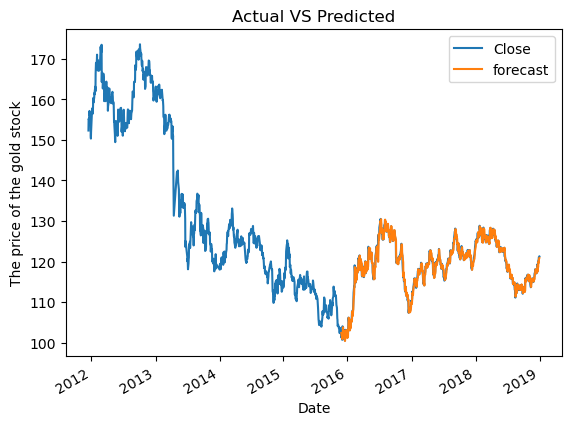

In [13]:
model=sm.tsa.statespace.SARIMAX(data['Close'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()
data['forecast']=results.predict(start=950)
data[['Close','forecast']].plot()
plt.title('Actual VS Predicted')
plt.ylabel('The price of the gold stock')
plt.show()

In [14]:
data = data[['Close','forecast']]
data.dropna(inplace=True)

### Evaluation metrics for ARIMA Model

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print('Mean absolute error : ', mean_absolute_error(data['Close'],data['forecast']))
print('Mean squared error : ', mean_squared_error(data['Close'],data['forecast']))
print('R2 error : ', r2_score(data['Close'],data['forecast']))

Mean absolute error :  0.6914696813298379
Mean squared error :  0.8998284550575315
R2 error :  0.9753062500760004


## <center> 2. Forecasting the Gold price using LSTM </center>

### Importing the data

In [16]:
!pip install tensorflow

In [17]:
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential

In [18]:
data = pd.read_csv('FINAL_USO.xls',usecols=['Close'])

### Preprocessing the Data

In [19]:
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler(feature_range=(0,1))
scaled_data = minmax.fit_transform(data)
train_data=scaled_data[:987,:]
valid_data=scaled_data[987:,:]

### Training split

In [20]:
x_train, y_train = [], []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

In [21]:
x_train, y_train = np.array(x_train), np.array(y_train)

### Reshaping the training data to fit the model

In [22]:
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

### Model creation

In [23]:
model = Sequential([LSTM(50,return_sequences=True,input_shape=(x_train.shape[1],1)),
                   LSTM(50),
                   Dense(1,activation='relu')])
model.compile(optimizer='adam', loss='mean_squared_error')

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


### Fitting the model

In [25]:
model.fit(x_train,y_train,epochs=5)

Epoch 1/5
29/29 [==============================] - 6s 44ms/step - loss: 0.0379
Epoch 2/5
29/29 [==============================] - 1s 46ms/step - loss: 0.0028
Epoch 3/5
29/29 [==============================] - 1s 44ms/step - loss: 0.0019
Epoch 4/5
29/29 [==============================] - 1s 43ms/step - loss: 0.0018
Epoch 5/5
29/29 [==============================] - 1s 44ms/step - loss: 0.0018


In [26]:
inputs_data = data[len(data)-len(valid_data)-60:].values

In [27]:
inputs_data=inputs_data.reshape(-1,1)
inputs_data=minmax.transform(inputs_data)

x_test=[]
for i in range(60,valid_data.shape[0]):
    x_test.append(scaled_data[i-60:i,0])
x_test=np.array(x_test)

### Forecasting the model

In [28]:
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

closing_price=model.predict(x_test)
closing_price=minmax.inverse_transform(closing_price)

21/21 [==============================] - 1s 17ms/step


### Plotting the Actual VS Forecasted values

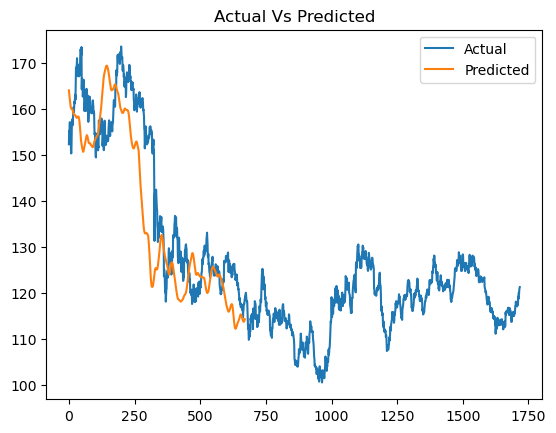

In [29]:
plt.plot(data["Close"],label='Actual')
plt.plot(closing_price,label='Predicted')
plt.title('Actual Vs Predicted')
plt.legend()
plt.show()